# can use snpashot_file and snapshot_interval so that we can run a model that takes a long time, and continue where we left off

In [75]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn
import catboost
from pylab import rcParams

In [76]:
data = pd.read_csv('Netflix_data.csv')
#print(tabulate(df, headers = 'firstrow', tablefmt = 'psql'))
print(data.head(5))
data.columns

    show_id     type                                    title  \
0  81145628    Movie  Norm of the North: King Sized Adventure   
1  80117401    Movie               Jandino: Whatever it Takes   
2  70234439  TV Show                       Transformers Prime   
3  80058654  TV Show         Transformers: Robots in Disguise   
4  80125979    Movie                             #realityhigh   

                   director  \
0  Richard Finn, Tim Maltby   
1                       NaN   
2                       NaN   
3                       NaN   
4          Fernando Lebrija   

                                                cast  \
0  Alan Marriott, Andrew Toth, Brian Dobson, Cole...   
1                                   Jandino Asporaat   
2  Peter Cullen, Sumalee Montano, Frank Welker, J...   
3  Will Friedle, Darren Criss, Constance Zimmer, ...   
4  Nesta Cooper, Kate Walsh, John Michael Higgins...   

                                    country date_added  release_year  \
0  United Sta

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

In [77]:
data.isnull().sum(axis=0)

show_id            0
type               0
title              0
director        1969
cast             570
country          476
date_added        11
release_year       0
rating            10
duration           0
listed_in          0
description        0
dtype: int64

In [3]:
data = data.drop(['director'], axis = 1)
data.head(5)

,show_id,type,title,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",9-Sep-19,2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,Jandino Asporaat,United Kingdom,9-Sep-16,2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,8-Sep-18,2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,8-Sep-18,2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,8-Sep-17,2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


In [4]:
data.isnull().sum(axis=0)/len(data)*100

show_id         0.000000
type            0.000000
title           0.000000
cast            9.143407
country         7.635547
date_added      0.176452
release_year    0.000000
rating          0.160411
duration        0.000000
listed_in       0.000000
description     0.000000
dtype: float64

In [5]:
data.shape

(6234, 11)

In [6]:
data.dropna(subset = ['date_added', 'rating'], how = 'any').shape
data = data.dropna(subset = ['date_added', 'rating'], how = 'any')

In [7]:
data.dropna(subset = ['country', 'cast'], how = 'all').shape
data = data.dropna(subset = ['country', 'cast'], how = 'all')

In [8]:
data['country'].value_counts(dropna = False)

United States                                          2023
India                                                   777
NaN                                                     391
United Kingdom                                          347
Japan                                                   174
Canada                                                  141
South Korea                                             136
Spain                                                   117
France                                                   90
Mexico                                                   83
Turkey                                                   79
Taiwan                                                   69
Australia                                                69
Hong Kong                                                51
Brazil                                                   50
Egypt                                                    50
Thailand                                

In [9]:
data[data['country'].isnull()]

,show_id,type,title,cast,country,date_added,release_year,rating,duration,listed_in,description
10,80169755,Movie,Joaquín Reyes: Una y no más,Joaquín Reyes,NaN,8-Sep-17,2017,TV-MA,78 min,Stand-Up Comedy,Comedian and celebrity impersonator Joaquín Re...
12,80182480,Movie,Krish Trish and Baltiboy,"Damandeep Singh Baggan, Smita Malhotra, Baba S...",NaN,8-Sep-17,2009,TV-Y7,58 min,Children & Family Movies,"A team of minstrels, including a monkey, cat a..."
13,80182483,Movie,Krish Trish and Baltiboy: Battle of Wits,"Damandeep Singh Baggan, Smita Malhotra, Baba S...",NaN,8-Sep-17,2013,TV-Y7,62 min,Children & Family Movies,"An artisan is cheated of his payment, a lion o..."
14,80182596,Movie,Krish Trish and Baltiboy: Best Friends Forever,"Damandeep Singh Baggan, Smita Malhotra, Deepak...",NaN,8-Sep-17,2016,TV-Y,65 min,Children & Family Movies,"A cat, monkey and donkey team up to narrate fo..."
15,80182482,Movie,Krish Trish and Baltiboy: Comics of India,"Damandeep Singh Baggan, Smita Malhotra, Baba S...",NaN,8-Sep-17,2012,TV-Y7,61 min,Children & Family Movies,"In three comic-strip-style tales, a boy tries ..."
16,80182597,Movie,Krish Trish and Baltiboy: Oversmartness Never ...,"Rishi Gambhir, Smita Malhotra, Deepak Chachra",NaN,8-Sep-17,2017,TV-Y7,65 min,Children & Family Movies,"A cat, monkey and donkey learn the consequence..."
17,80182481,Movie,Krish Trish and Baltiboy: Part II,"Damandeep Singh Baggan, Smita Malhotra, Baba S...",NaN,8-Sep-17,2010,TV-Y7,58 min,Children & Family Movies,Animal minstrels narrate stories about a monke...
18,80182621,Movie,Krish Trish and Baltiboy: The Greatest Trick,"Damandeep Singh Baggan, Smita Malhotra, Baba S...",NaN,8-Sep-17,2013,TV-Y7,60 min,Children & Family Movies,The consequences of trickery are explored in s...
26,80244601,TV Show,Castle of Stars,"Chaiyapol Pupart, Jintanutda Lummakanon, Worra...",NaN,7-Sep-18,2015,TV-14,1 Season,"International TV Shows, Romantic TV Shows, TV ...",As four couples with different lifestyles go t...
34,80221550,TV Show,Archibald's Next Big Thing,"Tony Hale, Rosamund Pike, Jordan Fisher, Chels...",NaN,6-Sep-19,2019,TV-Y7,1 Season,"Kids' TV, TV Comedies",Happy-go-lucky chicken Archibald may not remem...


In [10]:
data.isnull().sum(axis=0)

show_id           0
type              0
title             0
cast            487
country         391
date_added        0
release_year      0
rating            0
duration          0
listed_in         0
description       0
dtype: int64

In [11]:
data['country'] = data['country'].fillna('Other')
data['cast'] = data['cast'].fillna('Unknown')

In [12]:
data.isnull().sum(axis = 0)

show_id         0
type            0
title           0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

In [13]:
%matplotlib inline
rcParams['figure.figsize'] = 5, 4
sb.set_style('whitegrid')

## I used all variables as chi square candidate below

# data[data.columns[0]]
from scipy.stats import chi2_contingency
for i in range(11):
    n = 'description'
    table = pd.crosstab(data[n], data[data.columns[i]])
    chi2, p, dof, expected = chi2_contingency(table.values)
    print('Chi square result for columns %s and: %s' % (n, data.columns[i]))
    print('Chi-stat %0.3f p_value %0.3f' % (chi2, p))

data["date_added"] = pd.to_datetime(data['date_added'])
data['day_added'] = data['date_added'].dt.day
data['year_added'] = data['date_added'].dt.year
data['month_added']= data['date_added'].dt.month
data['year_added'].astype(string)
data['day_added'].astype(string)
data.head()

data.corr()
plt.figure(figsize=(12,10))
seaborn.heatmap(data.corr(), annot= True, cmap = "coolwarm")

In [14]:
data.nunique()

show_id         6134
type               2
title           6075
cast            5456
country          555
date_added      1518
release_year      71
rating            14
duration         199
listed_in        459
description     6126
dtype: int64

In [15]:
from sklearn.model_selection import train_test_split
x = data.drop(['show_id', 'type'], axis = 1)
y = data['type']

In [3]:
cat_features = list(range(0, x.shape[1]))
print(cat_features)

NameError: name 'x' is not defined

## I used this in order to view how many of each (TV or MOvie) were in each column, and i encoded each with numbers so that it would be summable

In [17]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
temp = le.fit_transform(y)
print('Labels: {}'.format(set(temp)))
print('Zero count = {}, One count = {}'.format(len(temp) - sum(temp), sum(temp)))
le.classes_

Labels: {0, 1}
Zero count = 4216, One count = 1918


array(['Movie', 'TV Show'], dtype=object)

In [18]:
from catboost import Pool
pool = Pool(data = x, label = y, cat_features = cat_features)

In [19]:
data = train_test_split(x, y, test_size = 0.2, random_state = 176)
x_train, x_validation, y_train, y_validation = data

train_pool = Pool(
    data = x_train,
    label = y_train,
    cat_features = cat_features)

validation_pool = Pool(
    data = x_validation,
    label = y_validation,
    cat_features = cat_features)

In [20]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations = 1000,
    verbose = 100,
    loss_function = 'Logloss',
    custom_loss = ['AUC', 'Accuracy'])

# Can't use the "plot" function in the model because catboost plots are it is incompatible with VS code

In [21]:
model.fit(
    train_pool,
    eval_set = validation_pool,
    verbose = 100
    )
#plot = True

Learning rate set to 0.04694
0:	learn: 0.5291512	test: 0.5228340	best: 0.5228340 (0)	total: 187ms	remaining: 3m 6s
100:	learn: 0.0024919	test: 0.0002806	best: 0.0002806 (100)	total: 4.12s	remaining: 36.7s
200:	learn: 0.0013061	test: 0.0001371	best: 0.0001371 (200)	total: 8.36s	remaining: 33.2s
300:	learn: 0.0009866	test: 0.0001095	best: 0.0001095 (298)	total: 12.3s	remaining: 28.6s
400:	learn: 0.0008602	test: 0.0001018	best: 0.0001018 (399)	total: 16.3s	remaining: 24.4s
500:	learn: 0.0008343	test: 0.0001006	best: 0.0001002 (441)	total: 20.2s	remaining: 20.1s
600:	learn: 0.0008134	test: 0.0001008	best: 0.0001002 (441)	total: 24.1s	remaining: 16s
700:	learn: 0.0008048	test: 0.0001015	best: 0.0001002 (441)	total: 28s	remaining: 12s
800:	learn: 0.0007910	test: 0.0001010	best: 0.0001002 (441)	total: 32.6s	remaining: 8.09s
900:	learn: 0.0007785	test: 0.0001008	best: 0.0001002 (441)	total: 36.5s	remaining: 4.01s
999:	learn: 0.0007748	test: 0.0001011	best: 0.0001002 (441)	total: 40.3s	remainin

In [78]:
print('Model is fitted: {}'.format(model.is_fitted()))
print('Model params\n{}'.format(model.get_params()))

Model is fitted: True
Model params
{'iterations': 1000, 'learning_rate': 0.04694, 'loss_function': 'Logloss', 'verbose': 100}


## Not really working, believe it is because it takes too much cpu

#used for cross-validation, to find best learning rate
from catboost import cv

params = {
    'loss_function': 'Logloss',
    'iterations': 100,
    'learning_rate': 0.5}

cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count = 5,
    shuffle = True,
    partition_random_seed = 0,
    verbose = False)

from sklearn.model_selection import train_test_split
x = data.drop(['show_id', 'type'], axis = 1)
y = data['type']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 176)

In [69]:
model = CatBoostClassifier(iterations = 1000, learning_rate = 0.04694)
model.fit(train_pool, verbose = 100)

0:	learn: 0.5291512	total: 30.7ms	remaining: 30.6s
100:	learn: 0.0024919	total: 4.22s	remaining: 37.6s
200:	learn: 0.0013061	total: 8.61s	remaining: 34.2s
300:	learn: 0.0009866	total: 13.1s	remaining: 30.3s
400:	learn: 0.0008602	total: 17.4s	remaining: 26.1s
500:	learn: 0.0008343	total: 21.9s	remaining: 21.8s
600:	learn: 0.0008134	total: 26.3s	remaining: 17.5s
700:	learn: 0.0008048	total: 30.3s	remaining: 12.9s
800:	learn: 0.0007910	total: 34.1s	remaining: 8.48s
900:	learn: 0.0007785	total: 38.3s	remaining: 4.21s
999:	learn: 0.0007748	total: 43.3s	remaining: 0us


# 3 ways to predict with this model

In [24]:
print(model.predict(x_validation))

['Movie' 'TV Show' 'Movie' ... 'TV Show' 'Movie' 'Movie']


In [25]:
print(model.predict_proba(x_validation))

[[9.99974626e-01 2.53737460e-05]
 [5.53389819e-05 9.99944661e-01]
 [9.99987714e-01 1.22862475e-05]
 ...
 [1.27138698e-04 9.99872861e-01]
 [9.99994016e-01 5.98353493e-06]
 [9.99987200e-01 1.28002655e-05]]


In [26]:
raw_pred = model.predict(
    x_validation,
    prediction_type = 'RawFormulaVal')

print(raw_pred)

[-10.58177017   9.80197764 -11.30701772 ...   8.97010481 -12.02649305
 -11.26603184]


In [27]:
from numpy import exp

sigmoid = lambda x: 1 / (1 + exp(-x))
probabilities = sigmoid(raw_pred)
print(probabilities)

[2.53737460e-05 9.99944661e-01 1.22862475e-05 ... 9.99872861e-01
 5.98353493e-06 1.28002655e-05]


In [28]:
import matplotlib.pyplot as pyplot
from catboost.utils import get_roc_curve
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

curve = get_roc_curve(model, validation_pool)
(fpr, tpr, thresholds) = curve
(thresholds, fpr) = get_fpr_curve(curve = curve)
(thresholds, fnr) = get_fnr_curve(curve = curve)

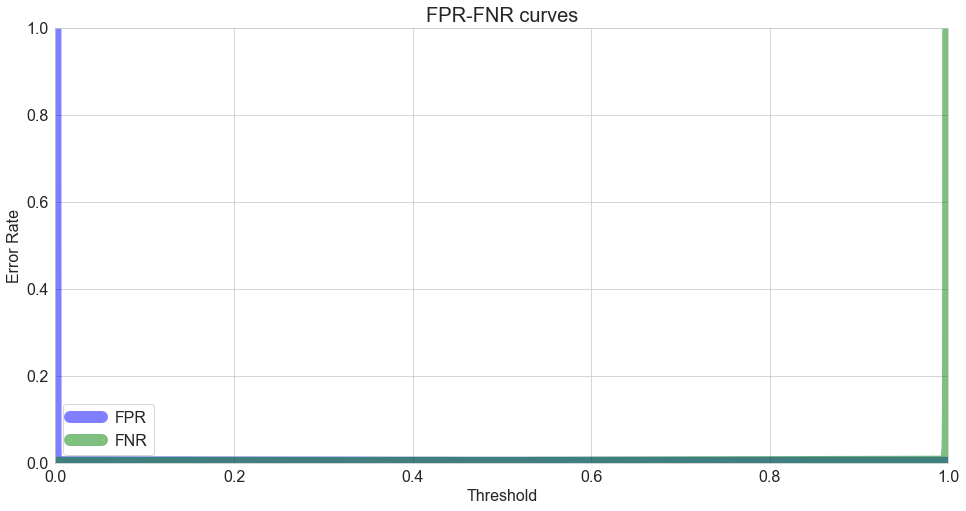

In [29]:
plt.figure(figsize = (16, 8))
style = {'alpha': 0.5, 'lw': 12}

plt.plot(thresholds, fpr, color = 'blue', label = 'FPR', **style)
plt.plot(thresholds, fnr, color = 'green', label = 'FNR', **style)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.grid(True)
plt.xlabel('Threshold', fontsize = 16)
plt.ylabel('Error Rate', fontsize = 16)
plt.title('FPR-FNR curves', fontsize = 20)
plt.legend(loc = 'lower left', fontsize = 16)

In [30]:
np.array(model.get_feature_importance(prettified = True))

array([['duration', 72.39794109379345],
       ['listed_in', 7.505217395047988],
       ['rating', 6.236849760862595],
       ['release_year', 5.627769701663274],
       ['country', 4.201349608476392],
       ['date_added', 3.966305467102223],
       ['cast', 0.06455860671370835],
       ['title', 8.366340327917712e-06],
       ['description', 0.0]], dtype=object)

In [31]:
np.array(model.get_feature_importance(
    train_pool,
    type = 'LossFunctionChange',
    prettified = True
))

array([['duration', 0.2080019078573839],
       ['listed_in', 0.0012123484417416429],
       ['country', 1.9603307584965234e-05],
       ['rating', 1.8967896320050604e-05],
       ['date_added', 1.1306831909903612e-05],
       ['release_year', 8.891980704556011e-06],
       ['cast', 1.8099194597931021e-07],
       ['title', 2.9291292594289375e-08],
       ['description', 0.0]], dtype=object)

In [32]:
print(model.predict_proba([x.iloc[1, :]]))
print(model.predict_proba([x.iloc[91, :]]))

[[9.99977639e-01 2.23605777e-05]]
[[9.99995824e-01 4.17614152e-06]]


In [33]:
shap_values = model.get_feature_importance(
    validation_pool,
    type = 'ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:, :-1]
print(shap_values.shape)

(1227, 9)


In [34]:
proba = model.predict_proba([x.iloc[1, :]])[0]
raw = model.predict([x.iloc[1, :]], prediction_type = 'RawFormulaVal')[0]
print('Probabilities', proba)
print('Raw formula value %.4f' % raw)
print('Probability from raw value %.4f' % sigmoid(raw))

Probabilities [9.99977639e-01 2.23605777e-05]
Raw formula value -10.7082
Probability from raw value 0.0000


In [35]:
import shap
shap.initjs()
shap.force_plot(expected_value, shap_values[1, :], x_validation.iloc[1, :])

In [36]:
proba = model.predict_proba([x.iloc[-1, :]])[0]
raw = model.predict([x.iloc[-1, :]], prediction_type = 'RawFormulaVal')[0]
print('Probabilities', proba)
print('Raw formula value %.4f' % raw)
print('Probability from raw value %.4f' % sigmoid(raw))

Probabilities [1.89798612e-04 9.99810201e-01]
Raw formula value 8.5694
Probability from raw value 0.9998


In [37]:
shap.initjs()
shap.force_plot(expected_value, shap_values[-1, :], x_validation.iloc[-1, :])

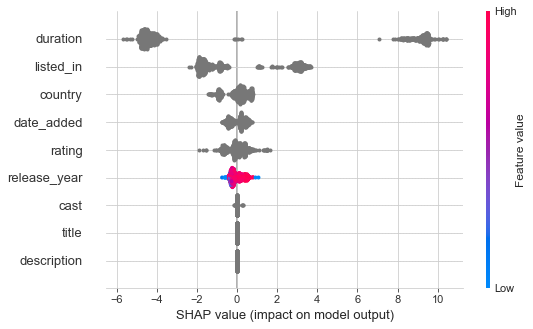

In [38]:
shap.summary_plot(shap_values, x_validation)

## couldnt figure out the confustion matrix

In [68]:
from catboost.utils import get_confusion_matrix
conf_matrix = get_confusion_matrix(model, Pool(x_train, y_train))
print(conf_matrix)

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=0]="The Lovers": Cannot convert 'b'The Lovers'' to float

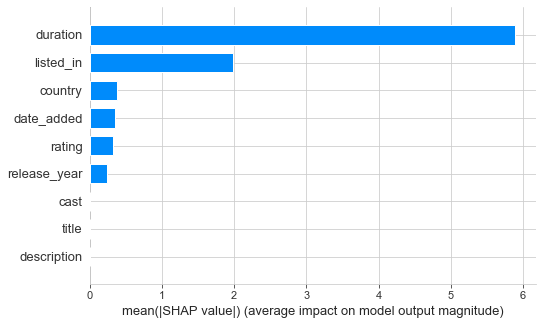

In [40]:
features_display = x.loc[cat_features]
shap.summary_plot(shap_values, features_display, plot_type = 'bar')

## couldn't get to work because of error:
EOL while scanning string literal

In [47]:
shap.dependence_plot(ind = 'duration',  interaction_index = 'listed_in', shap_values = shap_values, features = x_validation[:-1], display_features = features_display)

AssertionError: 'shap_values' and 'features' values must have the same number of rows!

## Doesn't worklk for a complicated reason: something like this -> https://github.com/slundberg/shap/issues/1272
This is probably a problem I cant fix on my ona

In [70]:
explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print("Explainer expected value: {expected_value}")

TypeError: object of type 'NoneType' has no len()

In [66]:
shap.decision_plot(expected_value, shap_values, cat_features)

TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'

In [72]:
shap.decision_plot(expected_value, shap_values, features_display, link = 'logit')

TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'

## Can also use a snapshot thing for catboost so it saves

In [73]:
model.save_model('catboost_netflix_data.bin')
model.save_model('catboost_netflix_data.json', format = 'json')

In [74]:
model.load_model('catboost_netflix_data.bin')
print(model.get_params())
print(model.learning_rate_)

{'iterations': 1000, 'learning_rate': 0.04694, 'loss_function': 'Logloss', 'verbose': 100}
0.04693999887


In [ ]:
# pd.get_dummies(data.type)

# print(data.isnull().sum(axis=0))

# print("distict values:", data['rating'])
# print(data.head(5))